In [2]:
# import all relevant libraries
%matplotlib notebook
import numpy as np 
import pandas as pd
from math import pi
import seaborn as sns
from scipy.stats import norm
from numpy.random import normal
from numpy.random import random
from numpy import vstack
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

Demonstrated below is a framework to run the Bayesian optimisation as a function. 

**n = number of experiments in data; m = number of input variables**

Inputs from the user:
- X [numpy ndarray - $n \times m$] (input variables)
- y [numpy ndarray - $n \times 1$] (output variable)
- xrange [numpy ndarray - $m \times 2$] (range of each input variable)
- meshdensity [integer] (density of prediction mesh)
- model [sklearn model] (surrogate function)
- acq_func [function] (acquisition function)

Output from the function: 
- Xmesh [
- ypred
- ystd
- next_expt

In [3]:
# define input and output variables

# Load the data
df45 = pd.read_csv("../data/DoE_Data_4_5.csv", index_col=0)
# Drop experiments without a value for %RH
df45 = df45.dropna()
df45 = df45.set_index([pd.Index(np.array(range(df45.shape[0])))])

df45

,ID,datetime,Annealing H2 (sccm),Growth H2 (sccm),Growth CH4 (sccm),Growth He (sccm),Cooling H2 (sccm),Cooling CH4 (sccm),Cooling He (sccm),Growth Time (min),Dew Point (C),Temperature (C),Relative Humidity (pct),Res: Graphene Presence,CP: Total Flow Rate (sccm),CP: CH4/Total,CP: CH4/H2,CP: Dil CH4,CP: Set No,Res: pct. Coverage
0,20200921_1,09/21/20 17:00,25,25,0.01716,476.69884,0,0.00000,475.00000,5.0,7.10,22.5,37.040835,No,501.716,0.000034,0.000686,True,4,0.000000
1,20200921_2,09/21/20 20:20,25,25,0.01716,476.69884,25,0.01716,476.69884,5.0,7.98,23.0,38.158064,No,501.716,0.000034,0.000686,True,4,0.000000
2,20200922_1,09/22/20 0:50,50,50,0.03432,953.39768,50,0.03432,953.39768,5.0,8.76,22.5,41.467763,Yes,1003.432,0.000034,0.000686,True,4,0.108187
3,20200922_2,09/22/20 10:50,50,50,0.03432,953.39768,50,0.03432,953.39768,5.0,11.38,22.5,49.407540,Yes,1003.432,0.000034,0.000686,True,4,0.134163
4,20200922_3,09/22/20 14:25,25,25,0.01716,476.69884,0,0.00000,475.00000,5.0,11.24,23.0,47.489815,No,501.716,0.000034,0.000686,True,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,20210509_2,05/09/21 16:20,18,18,0.12012,486.89188,18,0.12012,486.89188,7.0,5.40,21.5,35.016569,Yes,505.012,0.000238,0.006673,True,5,1.000000
72,20210510_1,05/10/21 1:55,20,20,0.08580,483.49420,20,0.08580,483.49420,7.0,5.80,22.0,34.917551,Yes,503.580,0.000170,0.004290,True,5,1.000000
73,20210510_2,05/10/21 4:40,20,20,0.08580,483.49420,20,0.08580,483.49420,7.0,5.70,23.0,32.632827,Yes,503.580,0.000170,0.004290,True,5,0.809141
74,20210510_3,05/10/21 7:40,18,18,0.12012,486.89188,18,0.12012,486.89188,7.0,4.60,22.0,32.123056,Yes,505.012,0.000238,0.006673,True,5,1.000000


In [4]:
# Create new dataframe with the experiment ID, output, continuous inputs and discrete inputs (in that order)
pidf45 = df45[["ID"]].copy()
pidf45["Coverage"] = df45["Res: pct. Coverage"]
pidf45["RH"] = df45["Relative Humidity (pct)"]

# --------------------
# pidf45["Time"] = df45["Growth Time (min)"]
# pidf45["Growth Flow Rate"] = df45["Growth CH4 (sccm)"]+df45["Growth H2 (sccm)"]+df45["Growth He (sccm)"]
pidf45["Total CH4 volume"] = df45["Growth Time (min)"]*df45["Growth CH4 (sccm)"]
# --------------------

pidf45["Cool/Grow CH4"] = df45["Cooling CH4 (sccm)"]/df45["Growth CH4 (sccm)"]

# --------------------
pidf45["Grow CH4/H2"] = df45["Growth CH4 (sccm)"]/df45["Growth H2 (sccm)"]
# pidf45["Grow CH4/Flow"] = df45["Growth CH4 (sccm)"]/(df45["Growth CH4 (sccm)"]+df45["Growth H2 (sccm)"]+df45["Growth He (sccm)"])
# --------------------

pidf45

,ID,Coverage,RH,Total CH4 volume,Cool/Grow CH4,Grow CH4/H2
0,20200921_1,0.000000,37.040835,0.08580,0.0,0.000686
1,20200921_2,0.000000,38.158064,0.08580,1.0,0.000686
2,20200922_1,0.108187,41.467763,0.17160,1.0,0.000686
3,20200922_2,0.134163,49.407540,0.17160,1.0,0.000686
4,20200922_3,0.000000,47.489815,0.08580,0.0,0.000686
...,...,...,...,...,...,...
71,20210509_2,1.000000,35.016569,0.84084,1.0,0.006673
72,20210510_1,1.000000,34.917551,0.60060,1.0,0.004290
73,20210510_2,0.809141,32.632827,0.60060,1.0,0.004290
74,20210510_3,1.000000,32.123056,0.84084,1.0,0.006673


In [5]:
X = pidf45.iloc[:,2:].to_numpy()
y = pidf45.iloc[:,1:2].to_numpy()
print(X.shape)
print(y.shape)

(76, 4)
(76, 1)


In [6]:
xrange = np.array([[15.0,65.0], # RH (%)
                   [0.0,1.3], # Total CH4 volume (scc)
                   [0.0,1.0], # C CH4 / G CH4
                   [0.0,0.01]]) # G CH4 / G H2

In [7]:
# define the model

kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.025)

In [8]:
# define the acquisition function

def acquisition(model, X, y, Xmesh, ypred, ystd):
    yhat, ybar = surrogate(model, X)
    best = max(yhat)
    Xsamples = Xmesh
    mu = ypred
    std = ystd
    scores = norm.cdf((mu - best) / (np.atleast_2d(std+1E-9).T))
    return scores

In [9]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

    
def BayesOpt(model, X, y, xrange, meshdensity=100):
    model.fit(X,y)
    print("Done: Model Fitting")
    
    grid = np.meshgrid(*[np.sort(np.unique(np.concatenate((np.linspace(xrange[i,0], xrange[i,1], meshdensity),np.unique(X[:,i]))))) if np.unique(X[:,i]).shape[0]<=10 else np.linspace(xrange[i,0], xrange[i,1], meshdensity) for i in range(xrange.shape[0])])
    print("Done: grid creation")
    Xmesh = np.concatenate(([np.atleast_2d(grid[i].ravel()).T for i in range(X.shape[1])]), axis=1)
    print("Done: Xmesh creation")
    ypred, ystd = surrogate(model,Xmesh)
    print("Done: Calculating ypred and ystd")
    
    scores = acquisition(model, X, y, Xmesh, ypred, ystd)
    print("Done: Calculating scores from the acquisition function")
    
    ix = np.argmax(scores)
    next_expt = Xmesh[ix]
    print("Done: Picking the next best experiment")
    
    return Xmesh, ypred, ystd, next_expt

In [10]:
Xmesh, ypred, ystd, next_expt = BayesOpt(gp, X, y, xrange, 50)

/Users/aagam2/Desktop/UIUC_Offline/DoE/Statistical_Analysis/StatAnalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Done: Model Fitting
Done: grid creation
Done: Xmesh creation
Done: Calculating ypred and ystd
Done: Calculating scores from the acquisition function
Done: Picking the next best experiment


In [11]:
# print the next best experiment

print("[RH, Total CH4 volume, Cool/Grow CH4, Grow CH4/H2]: ", next_expt)

[RH, Total CH4 volume, Cool/Grow CH4, Grow CH4/H2]:  [2.55263158e+01 1.30000000e+00 4.21052632e-01 1.00000000e-02]


### Plotting

In [12]:
# dataframe of all points in the mesh, their predicted values and standard deviations

plot_df = pd.DataFrame(np.concatenate((Xmesh, np.atleast_2d(ypred), np.atleast_2d(ystd).T), axis=1), columns=["RH","Total CH4 volume", "C/G CH4", "Grow CH4/H2", "ypred","ystd"])
plot_df

,RH,Total CH4 volume,C/G CH4,Grow CH4/H2,ypred,ystd
0,15.0,0.0,0.0,0.000000,-0.035111,0.088669
1,15.0,0.0,0.0,0.000526,-0.035098,0.088671
2,15.0,0.0,0.0,0.000686,-0.035094,0.088671
3,15.0,0.0,0.0,0.001053,-0.035084,0.088673
4,15.0,0.0,0.0,0.001579,-0.035071,0.088676
...,...,...,...,...,...,...
266795,65.0,1.3,1.0,0.007895,1.161113,0.249626
266796,65.0,1.3,1.0,0.008421,1.161126,0.249626
266797,65.0,1.3,1.0,0.008947,1.161140,0.249627
266798,65.0,1.3,1.0,0.009474,1.161153,0.249628


In [13]:
# numpy arrays of all unique values from [our expts + next best expt] for:
# 1. Total CH4 volume
total_ch4_val = np.unique(np.sort(np.append(np.unique(X[:,1]),next_expt[1])))

# 2. C/G CH4
cgch4_val = np.unique(np.sort(np.append(np.unique(X[:,2]),next_expt[2])))

# 3. Grow Ch4/H2
growch4h2_val = np.unique(np.sort(np.append(np.unique(X[:,3]),next_expt[3])))

print(total_ch4_val)
print(cgch4_val)
print(growch4h2_val)

[0.0858  0.1287  0.1716  0.2574  0.3432  0.6006  0.84084 0.858   1.2012
 1.3    ]
[0.         0.42105263 1.        ]
[0.0006864  0.00429    0.00667333 0.01      ]


In [44]:
# dataframe of all the experimental values
exp_df = pd.DataFrame(np.concatenate((X, np.atleast_2d(y)), axis=1), columns=["RH","Total CH4 volume","C/G CH4","Grow CH4/H2", "y"])

print(exp_df)
# print(exp_df_cg0.shape)
# print(exp_df_cg1.shape)
# print(exp_df_cg2.shape)

           RH  Total CH4 volume  C/G CH4  Grow CH4/H2         y
0   37.040835           0.08580      0.0     0.000686  0.000000
1   38.158064           0.08580      1.0     0.000686  0.000000
2   41.467763           0.17160      1.0     0.000686  0.108187
3   49.407540           0.17160      1.0     0.000686  0.134163
4   47.489815           0.08580      0.0     0.000686  0.000000
..        ...               ...      ...          ...       ...
71  35.016569           0.84084      1.0     0.006673  1.000000
72  34.917551           0.60060      1.0     0.004290  1.000000
73  32.632827           0.60060      1.0     0.004290  0.809141
74  32.123056           0.84084      1.0     0.006673  1.000000
75  31.446184           0.85800      1.0     0.004290  0.803470

[76 rows x 5 columns]


In [43]:
# testing

# x = np.array([]).shape
# a = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[0]) & (plot_df["C/G CH4"]==cgch4_val[0]) & (plot_df["Grow CH4/H2"]==growch4h2_val[0])]["RH"])
# b = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[0]) & (plot_df["C/G CH4"]==cgch4_val[0]) & (plot_df["Grow CH4/H2"]==growch4h2_val[0])]["RH"])

# np.concatenate((np.atleast_2d(x), np.atleast_2d(a),np.atleast_2d(b)), axis=0)
# if not "returningvariable" in locals():
#     print("lol")0

54//10

5

In [53]:
def simple_plot(total_ch4_val, cgch4_val, growch4h2_val, m, n, plot_df, exp_df):
    pl.figure(figsize=(10,10))
    ax = pl.subplot(projection='3d')
    
    x = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[0]) & 
                         (plot_df["C/G CH4"]==cgch4_val[m]) & 
                         (plot_df["Grow CH4/H2"]==growch4h2_val[n])]["RH"])

    for i in range(total_ch4_val.shape[0]):
#         if not "y" in locals():
#             y = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[i]) & 
#                          (plot_df["C/G CH4"]==cgch4_val[m]) & 
#                          (plot_df["Grow CH4/H2"]==growch4h2_val[n])]["Total CH4 volume"])
#         elif "y" in locals():
#             ytemp = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[i]) & 
#                          (plot_df["C/G CH4"]==cgch4_val[m]) & 
#                          (plot_df["Grow CH4/H2"]==growch4h2_val[n])]["ypred"])
#             y = np.concatenate((np.atleast_2d(y),np.atleast_2d(ytemp)), axis=0)

        y = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[i]) & 
                             (plot_df["C/G CH4"]==cgch4_val[m]) & 
                             (plot_df["Grow CH4/H2"]==growch4h2_val[n])]["Total CH4 volume"])
        z = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[i]) & 
                             (plot_df["C/G CH4"]==cgch4_val[m]) & 
                             (plot_df["Grow CH4/H2"]==growch4h2_val[n])]["ypred"])
        s = np.array(plot_df[(plot_df["Total CH4 volume"]==total_ch4_val[i]) & 
                             (plot_df["C/G CH4"]==cgch4_val[m]) & 
                             (plot_df["Grow CH4/H2"]==growch4h2_val[n])]["ystd"])
        
        yexp = np.array(exp_df[(exp_df["Total CH4 volume"]==total_ch4_val[i]) & 
                                (exp_df["C/G CH4"]==cgch4_val[m]) & 
                                (exp_df["Grow CH4/H2"]==growch4h2_val[n])]["Total CH4 volume"])
        zexp = np.array(exp_df[(exp_df["Total CH4 volume"]==total_ch4_val[i]) & 
                                (exp_df["C/G CH4"]==cgch4_val[m]) & 
                                (exp_df["Grow CH4/H2"]==growch4h2_val[n])]["y"])
        xexp = np.array(exp_df[(exp_df["Total CH4 volume"]==total_ch4_val[i]) & 
                                (exp_df["C/G CH4"]==cgch4_val[m]) & 
                                (exp_df["Grow CH4/H2"]==growch4h2_val[n])]["RH"])
        
        ax.plot(x, y, z, color=sns.color_palette("Blues")[5], linewidth = 5)
        
        ax.add_collection3d(pl.fill_between(x, (z - 1.9602*s), (z + 1.9602*s), 
                                            color=sns.color_palette("Blues")[(6*i)//total_ch4_val.shape[0]], 
                                            alpha=0.3), zs=total_ch4_val[i], zdir='y')
        
        ax.plot(xexp, yexp, zexp,'ro', markersize=10, label='Observations', mew=1, mec='k')
        
    ax.set_xlabel('RH (%)')
    ax.set_ylabel("Total CH4 volume (scc)")
    ax.set_zlabel('Coverage')

    ax.set_zlim(-1,1)

<IPython.core.display.Javascript object>


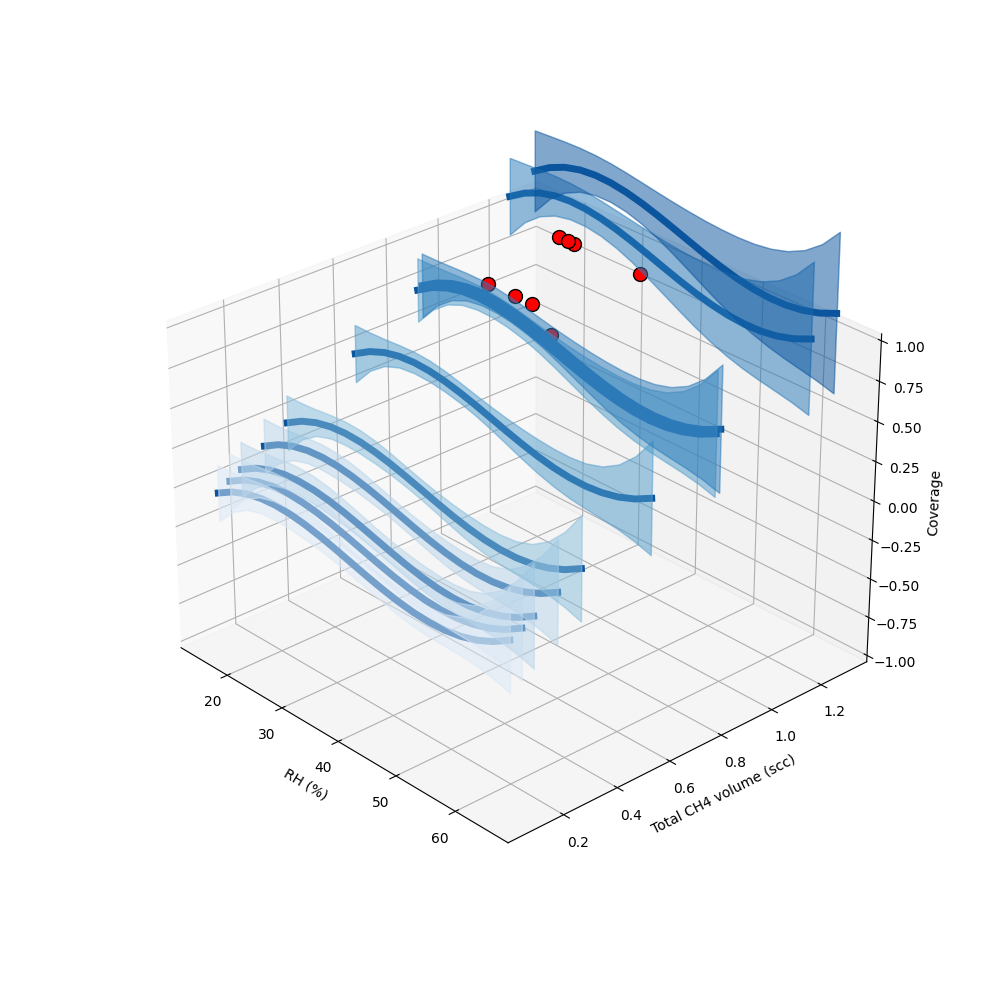

In [56]:
simple_plot(total_ch4_val, cgch4_val, growch4h2_val, 2, 2, plot_df, exp_df)

<IPython.core.display.Javascript object>


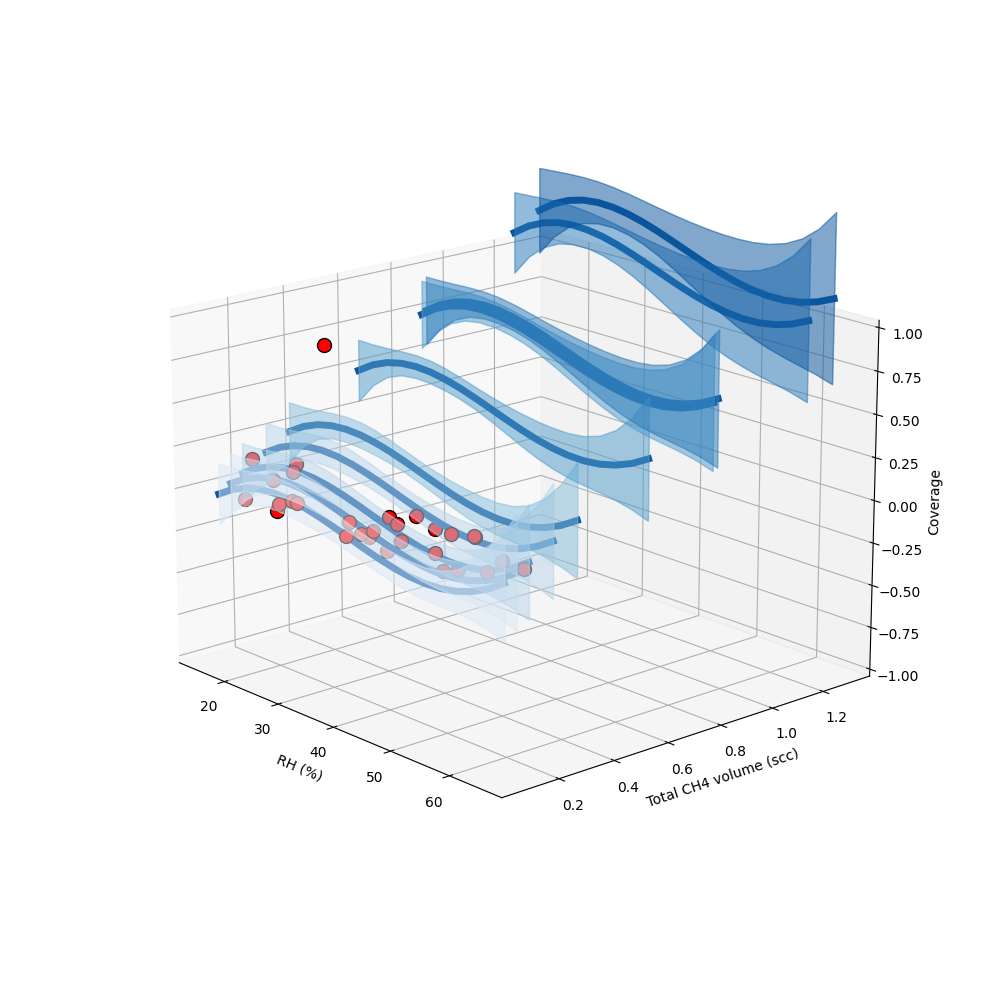

In [57]:
simple_plot(total_ch4_val, cgch4_val, growch4h2_val, 2, 0, plot_df, exp_df)